# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import optuna
import warnings

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix


warnings.filterwarnings("ignore")

# Model Pipeline

In [2]:
class CatBoostPipeline:
    """
    Class to preprocess the dataset and train the CatBoost model

    Attributes:
        train_df : DataFrame : Training DataFrame
        test_df : DataFrame : Test DataFrame
        categorical_features : List : Categorical features in the dataset
        numerical_features : List : Numerical features in the dataset
        model : CatBoostClassifier : Trained CatBoost model
        top_prop_categories : List : Top categories for 'proto' column
        top_service_categories : List : Top categories for 'service' column
        top_state_categories : List : Top categories for 'state' column
        corr_threshold : float : Correlation threshold for removing highly correlated features
        features_to_drop : List : Features to drop from the dataset

    Methods:
        basic_cleaning : Perform basic cleaning on the dataset
        identify_feature_types : Identify the feature types in the dataset
        handle_outliers : Handle outliers in the dataset
        convert_data_types : Convert the data types of the columns in the dataset
        selecting_categories : Select the top categories for the 'proto', 'service', and 'state' columns
        transform_categories : Transform the categories in the 'proto', 'service', and 'state' columns
        create_log1p_features : Create log1p features for the numerical columns in the dataset
        remove_highly_correlated_features : Remove highly correlated features from the dataset
        preprocess : Perform preprocessing on the dataset
        create_pool : Create a CatBoost Pool object
        train_model : Train the CatBoost model
        objective : Objective function for Optuna hyperparameter tuning
        optuna_tuning : Perform hyperparameter tuning using Optuna
        train_with_optuna : Train the CatBoost model with hyperparameter tuning using Optuna

    """
    def __init__(self, train_file_path, test_file_path):
        self.train_df = pd.read_parquet(train_file_path)
        self.test_df = pd.read_parquet(test_file_path)
        self.categorical_features = []
        self.numerical_features = []
        self.model = None
        self.top_prop_categories = None
        self.top_service_categories = None
        self.top_state_categories = None
        self.corr_threshold = 0.95
        self.features_to_drop = []  # Store features to drop

    def basic_cleaning(self, df):
        """
        Perform basic cleaning on the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : Cleaned DataFrame
        """
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'attack_cat', 'response_body_len']
        return df.drop(columns=columns_to_drop, axis=1)

    def identify_feature_types(self, df):
        """
        Identify the feature types in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            None
        """
        self.categorical_features = df.select_dtypes(include=['category', 'object']).columns.tolist()
        self.numerical_features = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32']).columns.tolist()
        self.numerical_features = [col for col in self.numerical_features if col != 'label']

    def handle_outliers(self, df):
        """
        Handle outliers in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with outliers handled
        """
        for column in self.numerical_features:
            lower_bound = df[column].quantile(0.001)
            upper_bound = df[column].quantile(0.999)
            df[column] = df[column].clip(lower_bound, upper_bound)
        return df

    def convert_data_types(self, df):
        """
        Convert the data types of the columns in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with converted data types
        """
        for column in self.categorical_features:
            df[column] = df[column].astype('category')
        for column in self.numerical_features:
            df[column] = df[column].astype('float32')
        return df

    def selecting_categories(self, df):
        """
        Select the top categories for the 'proto', 'service', and 'state' columns

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            Tuple : Top categories for 'proto', 'service', and 'state' columns
        """
        top_prop_categories = df['proto'].value_counts().head(6).index
        top_service_categories = df['service'].value_counts().head(8).index
        top_state_categories = df['state'].value_counts().head(5).index
        return top_prop_categories, top_service_categories, top_state_categories

    def transform_categories(self, df, top_prop_categories, top_service_categories, top_state_categories):
        """
        Transform the categories in the 'proto', 'service', and 'state' columns

        Args:
            df : DataFrame : Input DataFrame
            top_prop_categories : List : Top categories for 'proto' column
            top_service_categories : List : Top categories for 'service' column
            top_state_categories : List : Top categories for 'state' column

        Returns:
            DataFrame : DataFrame with transformed categories
        """
        df['proto'] = np.where(df['proto'].isin(top_prop_categories), df['proto'], '-')
        df['service'] = np.where(df['service'].isin(top_service_categories), df['service'], '-')
        df['state'] = np.where(df['state'].isin(top_state_categories), df['state'], '-')
        return df

    def create_log1p_features(self, df):
        """
        Create log1p features for the numerical columns in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with log1p features
        """
        log_features = [
            'smean', 'dmean',
            'sinpkt', 'dinpkt', 'sload', 'dload', 'sbytes', 'dbytes',
            'sjit', 'djit',
        ]
        for feature in log_features:
            if feature in df.columns:
                df[feature] = np.log1p(df[feature])

        return df
    
    def remove_highly_correlated_features(self, df, is_train=True):
        """
        Remove highly correlated features from the dataset

        Args:
            df : DataFrame : Input DataFrame
            is_train : bool : Whether the dataset is the training set

        Returns:
            DataFrame : DataFrame with highly correlated features removed
        """
        if is_train:
            corr_matrix = df[self.numerical_features].corr().abs()  # Get the correlation matrix of numerical features
            upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            # Find features that have a correlation greater than the threshold
            self.features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > self.corr_threshold)]
            print(f"Removing highly correlated features in training: {self.features_to_drop}")
        else:
            print(f"Removing same highly correlated features in test: {self.features_to_drop}")
        
        # Drop the highly correlated features (based on train set) from the dataframe
        df = df.drop(columns=self.features_to_drop, axis=1)

        # Update the numerical features list after dropping the highly correlated features
        self.numerical_features = [col for col in self.numerical_features if col not in self.features_to_drop]
        return df


    def preprocess(self, is_train=True):
        """
        Perform preprocessing on the dataset

        Args:
            is_train : bool : Whether the dataset is the training set

        Returns:
            Tuple : X, y
        """
        # Get the DataFrame based on whether it is the training set or not
        df = self.train_df if is_train else self.test_df

        # Basic cleaning
        df = self.basic_cleaning(df)

        # Identify feature types
        self.identify_feature_types(df)

        # Handle outliers
        df = self.handle_outliers(df) if is_train else df

        # Select top categories
        self.top_prop_categories, self.top_service_categories, self.top_state_categories = self.selecting_categories(df) if is_train else (self.top_prop_categories, self.top_service_categories, self.top_state_categories)

        # Transform categories
        df = self.transform_categories(df, self.top_prop_categories, self.top_service_categories, self.top_state_categories)
        
        # Log1p Feature Creation
        df = self.create_log1p_features(df)

        # Remove highly correlated features (use same features for both train and test)
        df = self.remove_highly_correlated_features(df, is_train=is_train)

        # Convert data types
        df = self.convert_data_types(df)
        
        # Separate features and target
        X = df.drop('label', axis=1)
        y = df['label']

        return X, y

    def create_pool(self, X, y=None):
        """
        Create a CatBoost Pool object

        Args:
            X : DataFrame : Input DataFrame
            y : DataFrame : Target DataFrame

        Returns:
            Pool : CatBoost Pool object
        """
        return Pool(
            data=X,
            label=y,
            cat_features=self.categorical_features
        )

    def train_model(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the CatBoost model

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target

        Returns:
            CatBoostClassifier : Trained CatBoost model
        """
        train_pool = self.create_pool(X_train, y_train)
        val_pool = self.create_pool(X_val, y_val) if X_val is not None else None

        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function='Logloss',
            eval_metric='AUC',
            task_type= 'GPU',
            random_seed=17,
            class_weights={0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])},  # Handle class imbalance
            verbose=100
        )

        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=100
        )

        return model

    def objective(self, trial, X_train, y_train, X_val, y_val):
        """
        Objective function for Optuna hyperparameter tuning

        Args:
            trial : Trial : Optuna trial object
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target

        Returns:
            float : AUC score
        """
        # Define the hyperparameters to be tuned
        params = {
            'iterations': trial.suggest_int('iterations', 400, 1200),
            'learning_rate': trial.suggest_float('learning_rate', 1e-2, 3e-1),
            'depth': trial.suggest_int('depth', 4, 16),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
            'random_seed': 17,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'task_type': 'GPU',  # Enable GPU
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
            'class_weights': {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])},  # Handle class imbalance
        }

        # Additional parameters for Bayesian bootstrap
        if params['bootstrap_type'] == 'Bayesian':
            params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
        elif params['bootstrap_type'] == 'Bernoulli':
            params['subsample'] = trial.suggest_float('subsample', 0.5, 1)

        # Create CatBoost Pool objects for train and validation sets
        train_pool = self.create_pool(X_train, y_train)
        val_pool = self.create_pool(X_val, y_val)

        # Initialize and train the CatBoost model
        model = CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=100,
            early_stopping_rounds= 100  # Add early stopping here
        )

        # Get the best AUC score from the validation set
        auc = model.get_best_score()['validation']['AUC']

        return auc

    def optuna_tuning(self, X_train, y_train, X_val, y_val, n_trials=50):
        """
        Perform hyperparameter tuning using Optuna

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target
            n_trials : int : Number of Optuna trials

        Returns:
            Dict : Best hyperparameters
        """
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.objective(trial, X_train, y_train, X_val, y_val), n_trials=n_trials)

        # Print and return the best parameters found by Optuna
        print("Best hyperparameters: ", study.best_params)
        print("Best AUC: ", study.best_value)

        return study.best_params

    def train_with_optuna(self, X_train, y_train, X_val, y_val, tune=True, n_trials=50):
        """
        Train the CatBoost model with hyperparameter tuning using Optuna

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target
            n_trials : int : Number of Optuna trials

        Returns:
            CatBoostClassifier : Trained CatBoost model
        """
        if(tune):
            # Tune hyperparameters
            best_params = self.optuna_tuning(X_train, y_train, X_val, y_val, n_trials)
        else:
            best_params = {'iterations': 4545, 'learning_rate': 0.034781065245863746, 'depth': 9, 'l2_leaf_reg': 4.974504622139129, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17707455985311188}
        # Train the model with the best hyperparameters
        train_pool = self.create_pool(X_train, y_train)
        val_pool = self.create_pool(X_val, y_val)

        model = CatBoostClassifier(
            **best_params,
            task_type='GPU',  # Ensure GPU usage
            eval_metric='AUC',
            random_seed=17,
            verbose=100,
            class_weights={0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
        )

        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=100,
            early_stopping_rounds= 100  # Add early stopping here
        )

        return model

In [ ]:
# Define the paths to the training and testing datasets
train_path = ''
test_path = ''

In [4]:
# Usage example
pipeline = CatBoostPipeline(train_path, test_path)

# Preprocess training data
X_train, y_train = pipeline.preprocess(is_train=True)
X_test, y_test = pipeline.preprocess(is_train=False)

# Split into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=17)

Removing highly correlated features in training: ['dloss', 'synack', 'ackdat', 'dmean', 'ct_ftp_cmd']
Removing same highly correlated features in test: ['dloss', 'synack', 'ackdat', 'dmean', 'ct_ftp_cmd']


In [5]:
# Train baseline model
model = pipeline.train_model(X_train, y_train, X_val, y_val)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9406537	best: 0.9406537 (0)	total: 12.3s	remaining: 3h 24m 6s
100:	test: 0.9770193	best: 0.9770193 (100)	total: 14.4s	remaining: 2m 8s
200:	test: 0.9786920	best: 0.9786920 (200)	total: 16.6s	remaining: 1m 6s
300:	test: 0.9790505	best: 0.9790505 (300)	total: 18.8s	remaining: 43.6s
400:	test: 0.9792953	best: 0.9793031 (395)	total: 20.9s	remaining: 31.3s
500:	test: 0.9794262	best: 0.9794262 (500)	total: 23.1s	remaining: 23s
600:	test: 0.9795108	best: 0.9795108 (600)	total: 25.3s	remaining: 16.8s
700:	test: 0.9795111	best: 0.9795270 (690)	total: 27.4s	remaining: 11.7s
800:	test: 0.9795713	best: 0.9795971 (785)	total: 29.7s	remaining: 7.37s
900:	test: 0.9796284	best: 0.9796284 (900)	total: 31.9s	remaining: 3.5s
999:	test: 0.9795990	best: 0.9796501 (920)	total: 34s	remaining: 0us
bestTest = 0.97965011
bestIteration = 920
Shrink model to first 921 iterations.


In [6]:
# Create test pool and make predictions
test_pool = pipeline.create_pool(X_test)
predictions = model.predict(test_pool)
predictions_prob = model.predict_proba(test_pool)[:, 1]

F1 Score: 0.9142330288605858
Precision: 0.8879216992919616
Recall: 0.9421513169524482
AUC: 0.9790193231745836


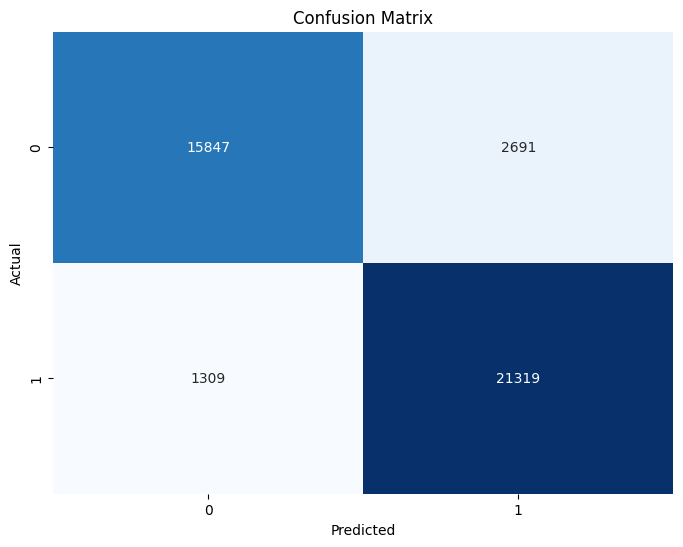

In [7]:
# Compute metrics
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_prob)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

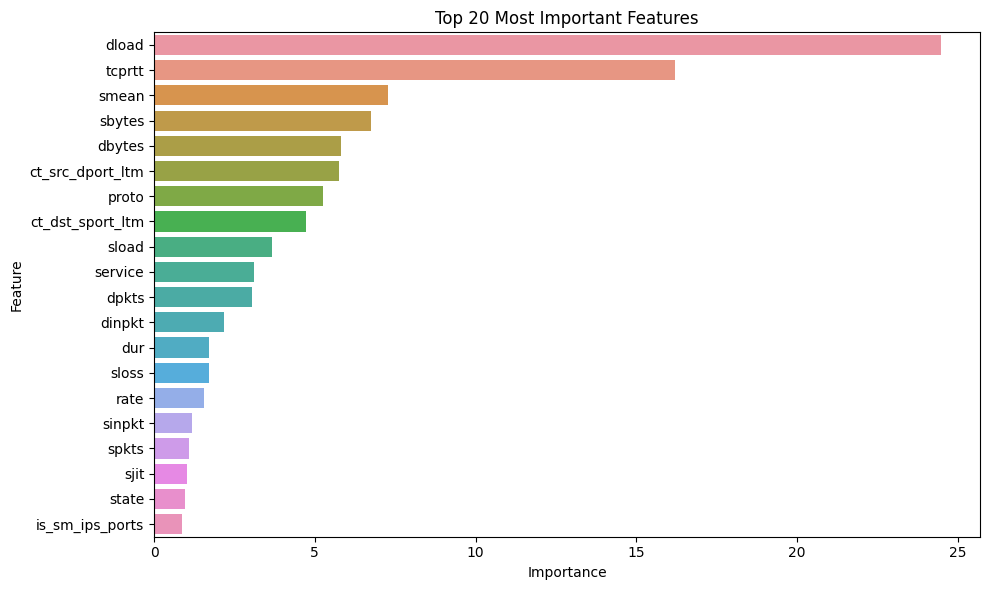

In [8]:
# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

def plot_feature_importance(top_n=20):
    """Plots the top N important features."""

    # Select top N features
    top_features = features_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance()

In [9]:
# Train the model with hyperparameter tuning
model = pipeline.train_with_optuna(X_train, y_train, X_val, y_val, tune=False, n_trials=50)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9628063	best: 0.9628063 (0)	total: 60.7ms	remaining: 4m 35s
100:	test: 0.9775341	best: 0.9775341 (100)	total: 6.08s	remaining: 4m 27s
200:	test: 0.9791119	best: 0.9791119 (200)	total: 12s	remaining: 4m 20s
300:	test: 0.9797949	best: 0.9797969 (297)	total: 17.9s	remaining: 4m 13s
400:	test: 0.9801526	best: 0.9801526 (398)	total: 23.9s	remaining: 4m 7s
500:	test: 0.9803380	best: 0.9803388 (489)	total: 29.9s	remaining: 4m 1s
600:	test: 0.9804087	best: 0.9804150 (586)	total: 35.9s	remaining: 3m 55s
700:	test: 0.9803909	best: 0.9804357 (651)	total: 41.8s	remaining: 3m 49s
bestTest = 0.9804356694
bestIteration = 651
Shrink model to first 652 iterations.


In [10]:
# Create test pool and make predictions
test_pool = pipeline.create_pool(X_test)
predictions = model.predict(test_pool)
predictions_prob = model.predict_proba(test_pool)[:, 1]

F1 Score: 0.9154309993347782
Precision: 0.8897509698410712
Recall: 0.9426374403394026
AUC: 0.9799249859820971


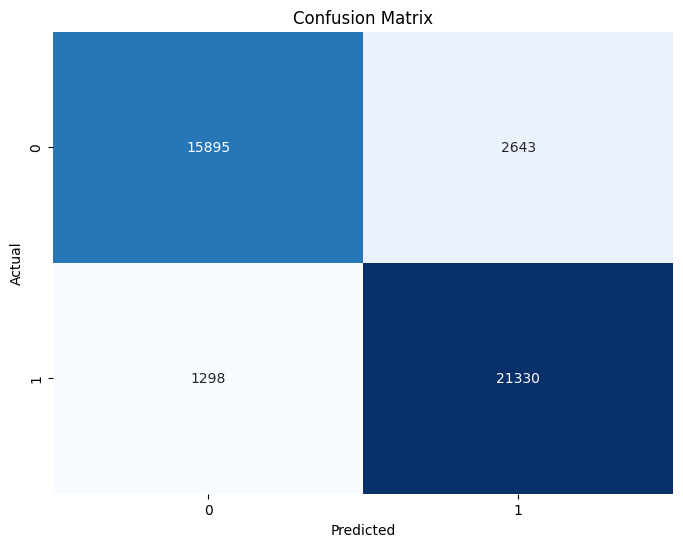

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute metrics
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_prob)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


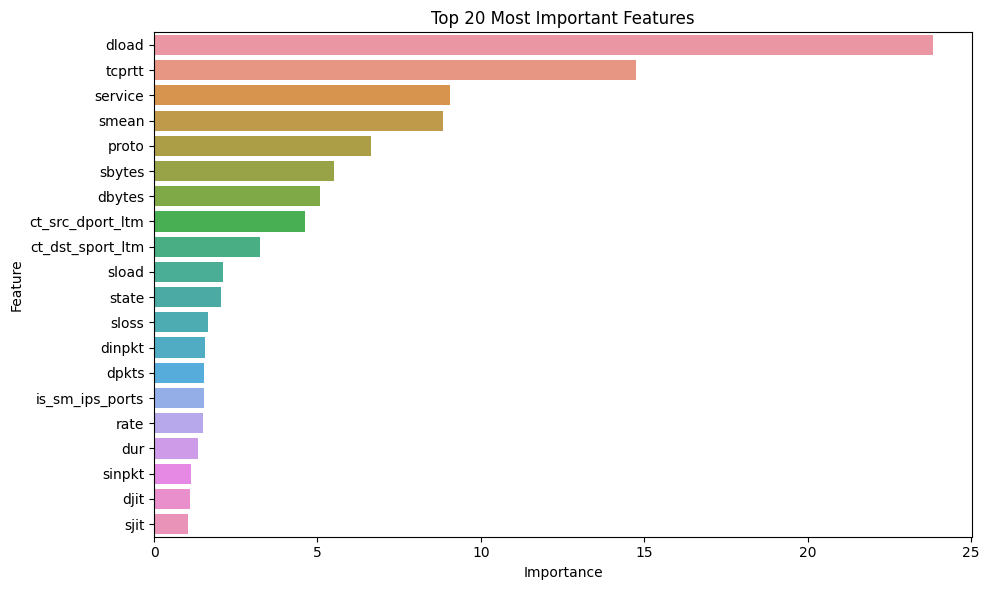

In [12]:
# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

def plot_feature_importance(top_n=20):
    """Plots the top N important features."""

    # Select top N features
    top_features = features_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance()